In [1]:
import sys
import tensorflow as tf
import scipy.io
from scipy.io import loadmat
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d
from glob import glob
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
sys.path.append("..")
from config import PATH_TO_AFF_MNIST_DATA
from spatial_transform.aff_mnist_data import IMAGE_SIZE, IMAGE_SHAPE, IMAGE_NUM_CHANNELS, get_aff_mnist_data
from spatial_transform.spatial_transforms import AffineTransform
from spatial_transform.st_blocks import SimpleSpatialTransformBlock
from spatial_transform.localization import StandardConvolutionalLocalizationLayer
from spatial_transform.interpolation import BilinearInterpolator
from spatial_transform.visualization import show_train_progress

In [3]:
train_img_data, train_img_label, validation_img_data, validation_img_label, test_img_data, test_img_label = get_aff_mnist_data()

In [4]:
image = tf.keras.layers.Input(shape=IMAGE_SHAPE + (IMAGE_NUM_CHANNELS,))
size_after_transform = 40

spatial_transform = AffineTransform()
st_block = SimpleSpatialTransformBlock(
    localization_layer = StandardConvolutionalLocalizationLayer(
        spatial_transform_params_cls = spatial_transform.param_type,
        init_scale = size_after_transform / IMAGE_SIZE,
    ),
    spatial_transform = spatial_transform,
    interpolator = BilinearInterpolator(),
    shape_out = (size_after_transform, size_after_transform)
)

x = image
x = st_block(x)
x = tf.keras.layers.Conv2D(32, [7, 7], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(32, [5, 5], activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(40, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(10, activation=None)(x)

model = tf.keras.models.Model(inputs=image, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
simple_spatial_transform_blo (None, 40, 40, 1)         19494     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        1600      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0     

In [5]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [6]:
history = model.fit(
    x = train_img_data, 
    y = train_img_label, 
    batch_size = 128,
    epochs = 10,
    validation_data = (test_img_data,  test_img_label),
    validation_batch_size = 1024,
)

Epoch 1/10
12500/12500 [==============================] - 325s 25ms/step - loss: 1.0615 - accuracy: 0.6374 - val_loss: 0.0605 - val_accuracy: 0.9807
Epoch 2/10
12500/12500 [==============================] - 281s 22ms/step - loss: 0.0560 - accuracy: 0.9825 - val_loss: 0.0399 - val_accuracy: 0.9872
Epoch 3/10
12500/12500 [==============================] - 314s 25ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.0368 - val_accuracy: 0.9885
Epoch 4/10
12500/12500 [==============================] - 289s 23ms/step - loss: 0.0303 - accuracy: 0.9904 - val_loss: 0.0318 - val_accuracy: 0.9899
Epoch 5/10
12500/12500 [==============================] - 276s 22ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0264 - val_accuracy: 0.9915
Epoch 6/10
12500/12500 [==============================] - 271s 22ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0282 - val_accuracy: 0.9910
Epoch 7/10
12500/12500 [==============================] - 271s 22ms/step - loss: 0.0190 - accuracy: 0.9939

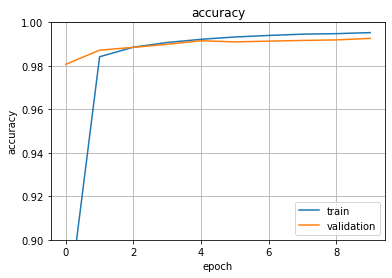

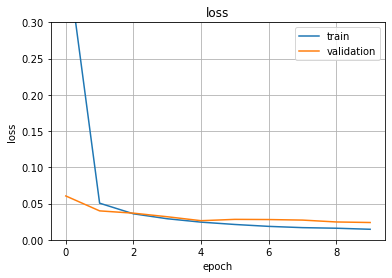

In [8]:
show_train_progress(history)

In [9]:
# model.save(filepath="experiments/STN_C0_backbone.h5")